In [2]:
#importing Data and Packages

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import warnings
import xgboost as xgb
import lightgbm as lgb
from scipy.stats import skew
from scipy import stats
from scipy.stats.stats import pearsonr
from scipy.stats import norm
from collections import Counter
from sklearn.linear_model import LinearRegression,LassoCV, Ridge, LassoLarsCV,ElasticNetCV
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler
warnings.filterwarnings('ignore')
sns.set(style='white', context='notebook', palette='deep')
%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline
import os
path=r"C:\Users\rchukka\Desktop\Rajesh\MachineHack"
os.chdir(path)
import datetime
import time


In [3]:
# Load train and Test set
train = pd.read_csv("./train_data.csv")
test = pd.read_csv("./test_data.csv")

In [4]:
# Check the numbers of samples and features
print("train data size  : {} ".format(train.shape))
print("test data size  : {} ".format(test.shape))


train data size  : (13320, 9) 
test data size  : (1480, 9) 


In [5]:
train.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [6]:
test.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,Ready To Move,Brookefield,2 BHK,Roeekbl,1225,2.0,2.0,NaN
1,Plot Area,Ready To Move,Akshaya Nagar,9 Bedroom,NaN,2400,9.0,2.0,NaN
2,Plot Area,18-Apr,Hennur Road,4 Bedroom,Saandtt,1650,5.0,2.0,NaN
3,Super built-up Area,Ready To Move,Kodichikkanahalli,3 BHK,Winerri,1322,3.0,1.0,NaN
4,Super built-up Area,Ready To Move,Konanakunte,2 BHK,AmageSa,1161,2.0,1.0,NaN


In [7]:
# Getting Description
train['price'].describe()

count    13320.000000
mean       112.565627
std        148.971674
min          8.000000
25%         50.000000
50%         72.000000
75%        120.000000
max       3600.000000
Name: price, dtype: float64


 mu = 112.57 and sigma = 148.97



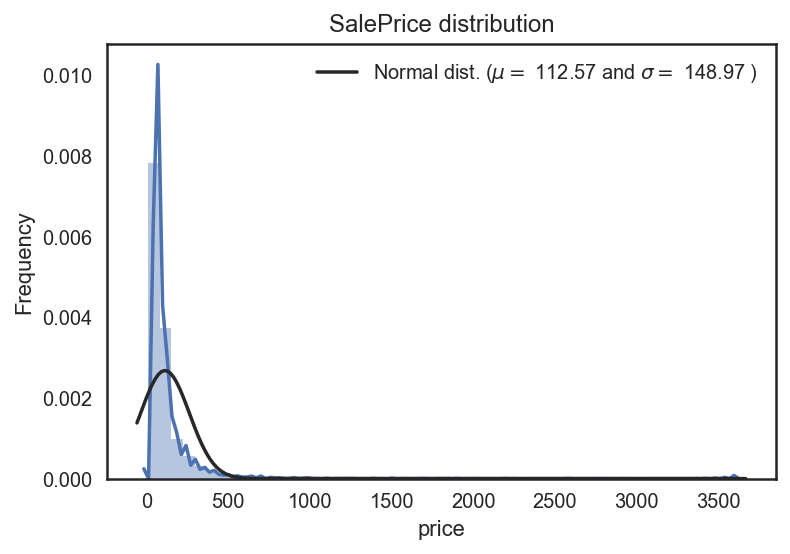

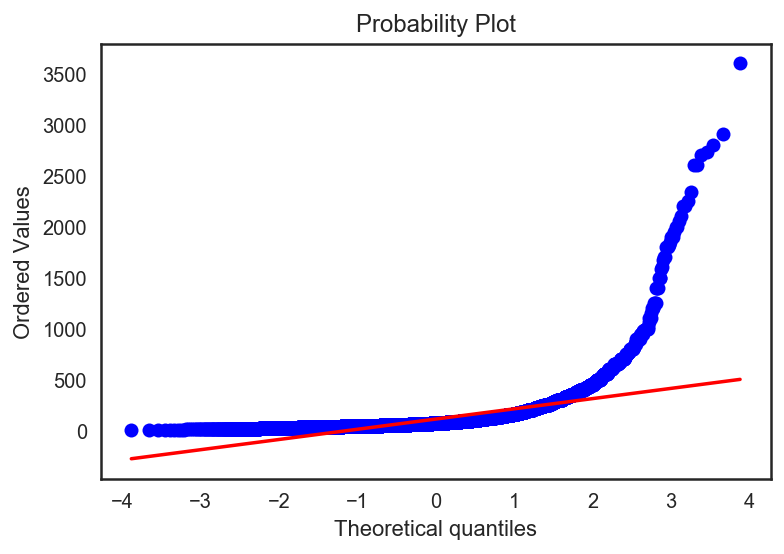

Skewness: 8.064469
Kurtosis: 108.166513


In [8]:
# Plot Histogram
sns.distplot(train['price'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['price'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig = plt.figure()
res = stats.probplot(train['price'], plot=plt)
plt.show()

print("Skewness: %f" % train['price'].skew())
print("Kurtosis: %f" % train['price'].kurt())

In [9]:
#cheking Data types 
train.dtypes

area_type        object
availability     object
location         object
size             object
society          object
total_sqft       object
bath            float64
balcony         float64
price           float64
dtype: object

In [10]:
#changing data type of particular columns 
train['new_size']=train['size'].str.extract('(\d+)').astype(float)
train['new_sqft']=train['total_sqft'].str.extract('(\d+)').astype(float)
test['new_sqft']=test['total_sqft'].str.extract('(\d+)').astype(float)
test['new_size']=test['size'].str.extract('(\d+)').astype(float)

In [11]:
#Droping un used columns 
train.drop("total_sqft", axis = 1, inplace = True)
test.drop("total_sqft", axis = 1, inplace = True)
train.drop("size", axis = 1, inplace = True)
test.drop("size", axis = 1, inplace = True)

In [12]:
#Multivariable Analysis
# Checking Categorical Data
train.select_dtypes(include=['object']).columns

Index(['area_type', 'availability', 'location', 'society'], dtype='object')

In [13]:
#Checking neumerical data 
train.select_dtypes(include=['int64','float64']).columns

Index(['bath', 'balcony', 'price', 'new_size', 'new_sqft'], dtype='object')

In [14]:
#Total features 
cat = len(train.select_dtypes(include=['object']).columns)
num = len(train.select_dtypes(include=['int64','float64']).columns)
print('Total Features: ', cat, 'categorical', '+',
      num, 'numerical', '=', cat+num, 'features')

Total Features:  4 categorical + 5 numerical = 9 features


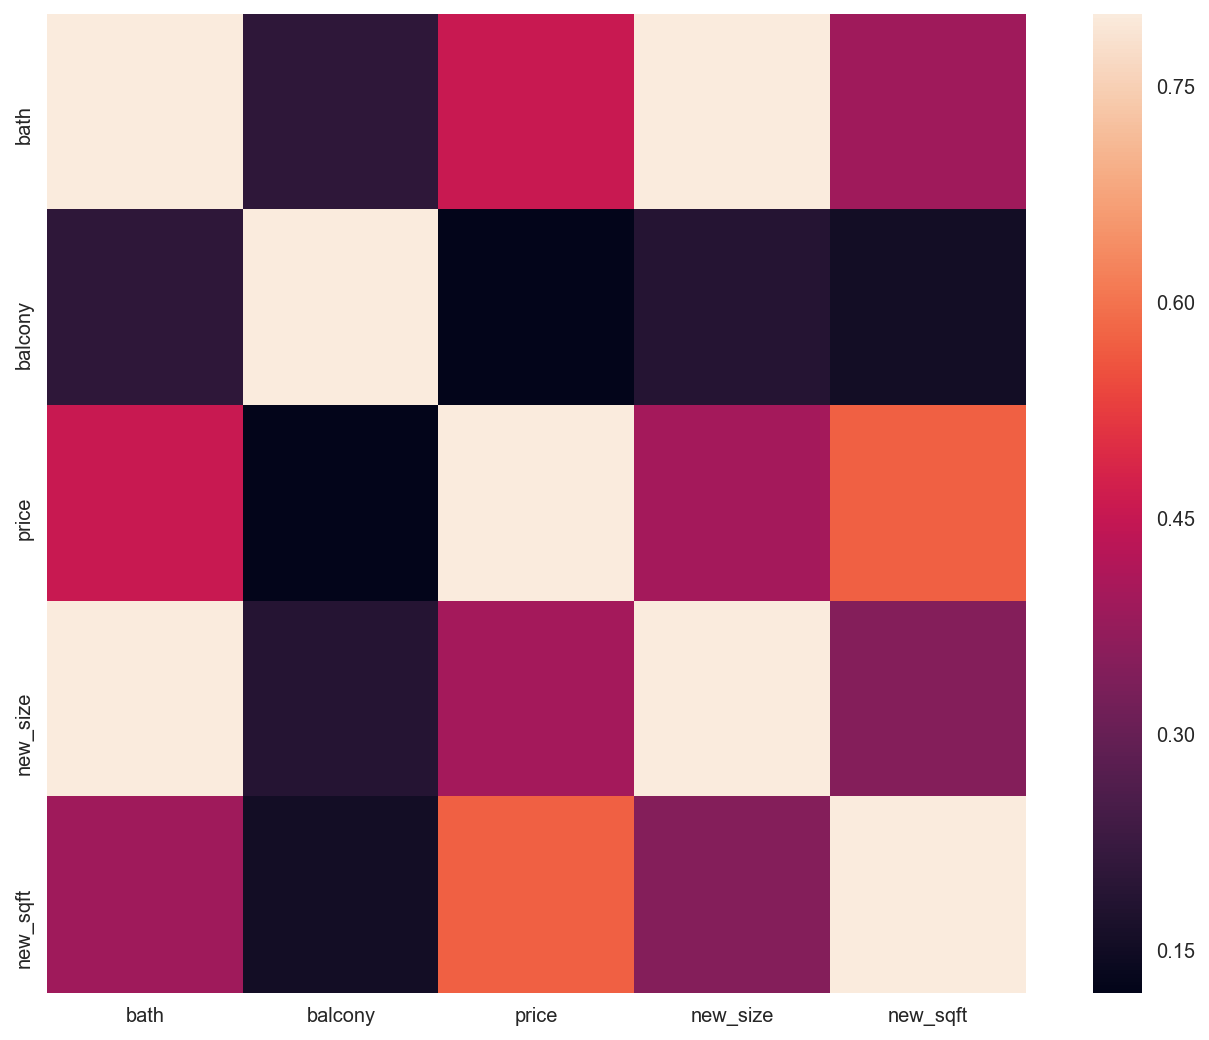

In [15]:
# Correlation Matrix Heatmap
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

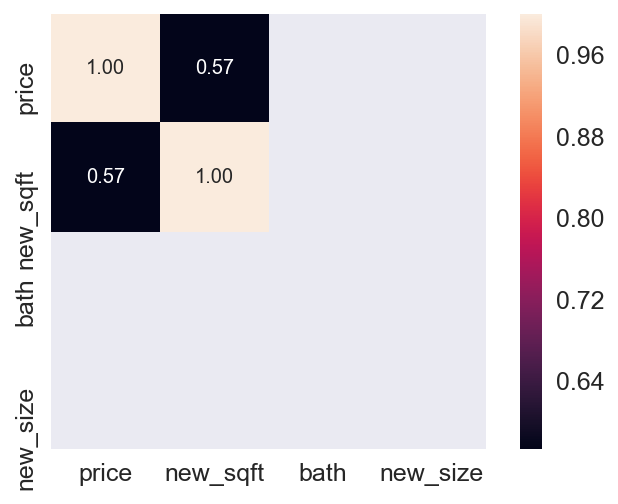

In [16]:
# Top 1 Heatmap
k = 4#number of variables for heatmap
cols = corrmat.nlargest(k, 'price')['price'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [17]:
#finding most correlated Features 
most_corr = pd.DataFrame(cols)
most_corr.columns = ['Most Correlated Features']
most_corr

,Most Correlated Features
0,price
1,new_sqft
2,bath
3,new_size


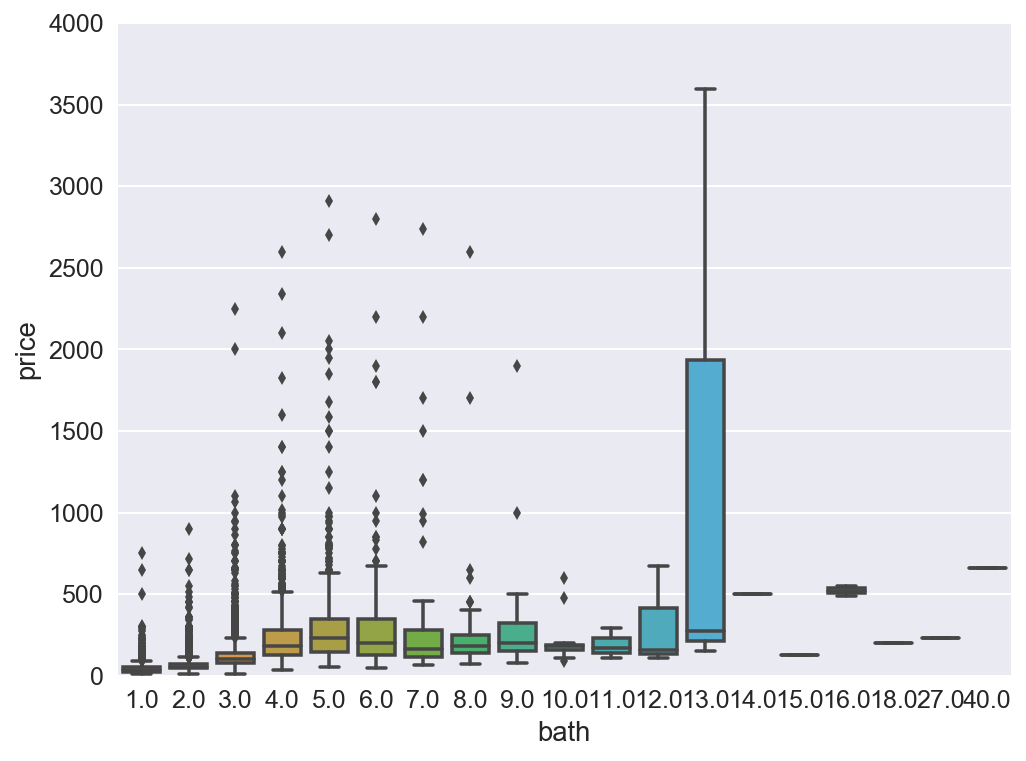

In [18]:
# bath vs  Price
var = 'bath'
data = pd.concat([train['price'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="price", data=data)
fig.axis(ymin=0, ymax=4000);


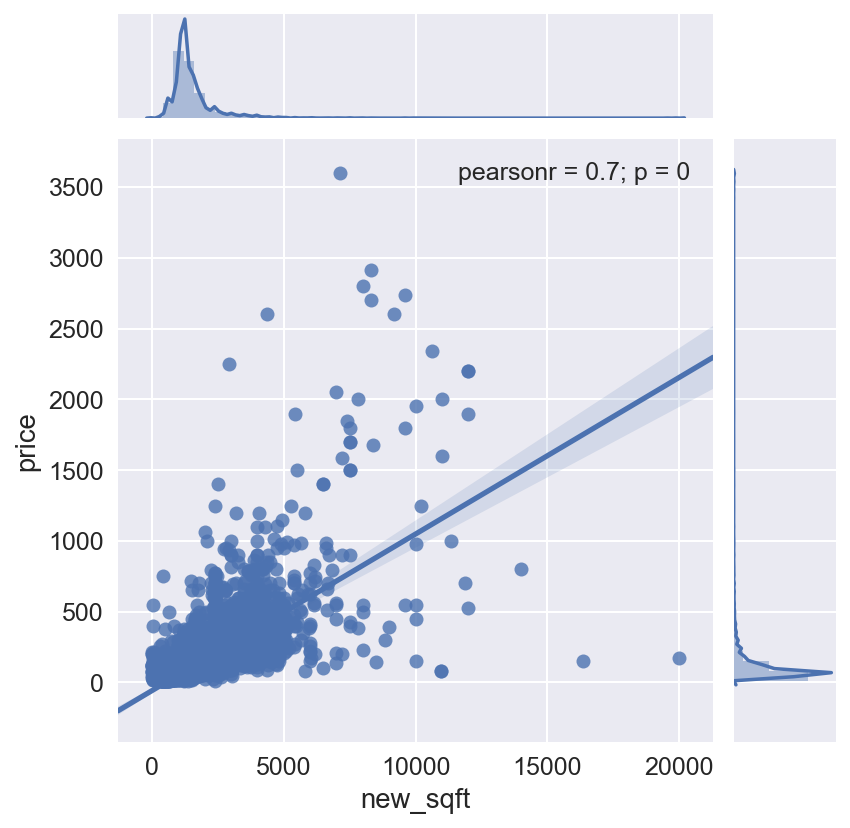

In [23]:
# Square feet vs Sale Price
sns.jointplot(x=train['new_sqft'], y=train['price'], kind='reg')

In [24]:
# Removing outliers manually (Two points in the bottom right)
train = train.drop(train[(train['new_sqft']>20000) 
                         & (train['price']<3000)].index).reset_index(drop=True)

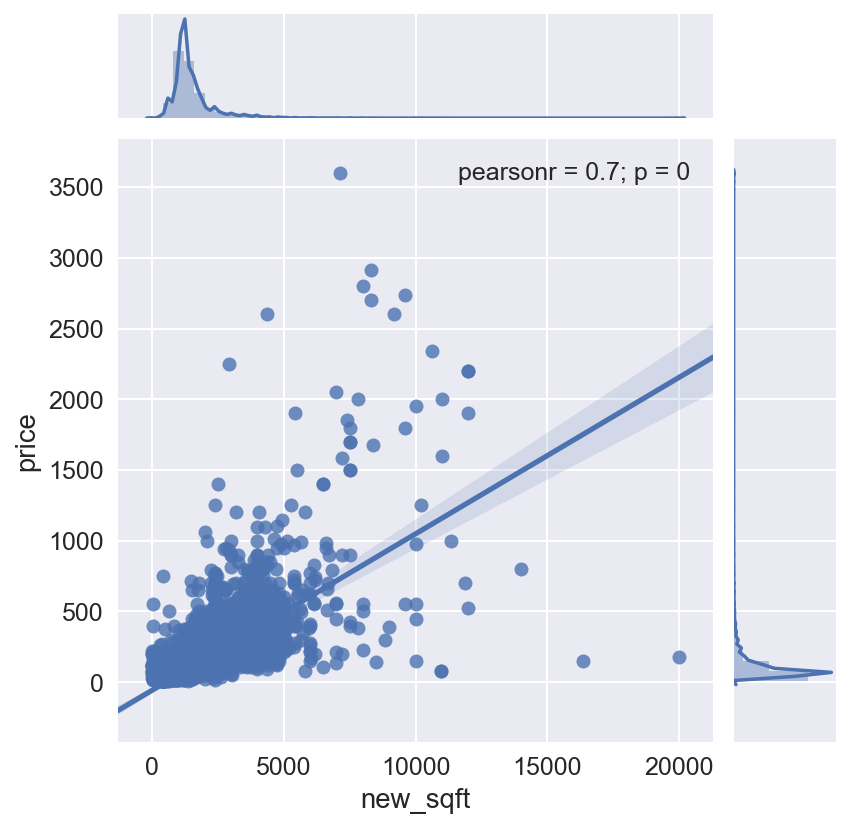

In [25]:
sns.jointplot(x=train['new_sqft'], y=train['price'], kind='reg')

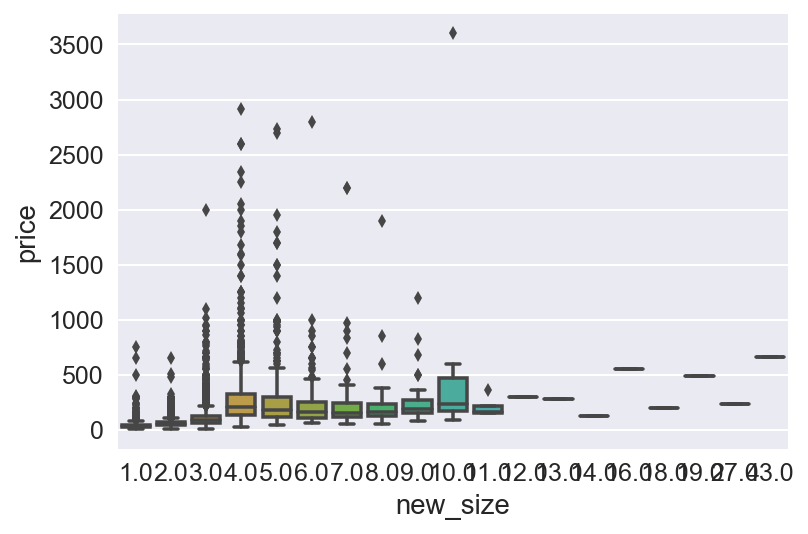

In [26]:
# size vs  Price
sns.boxplot(x=train['new_size'], y=train['price'])

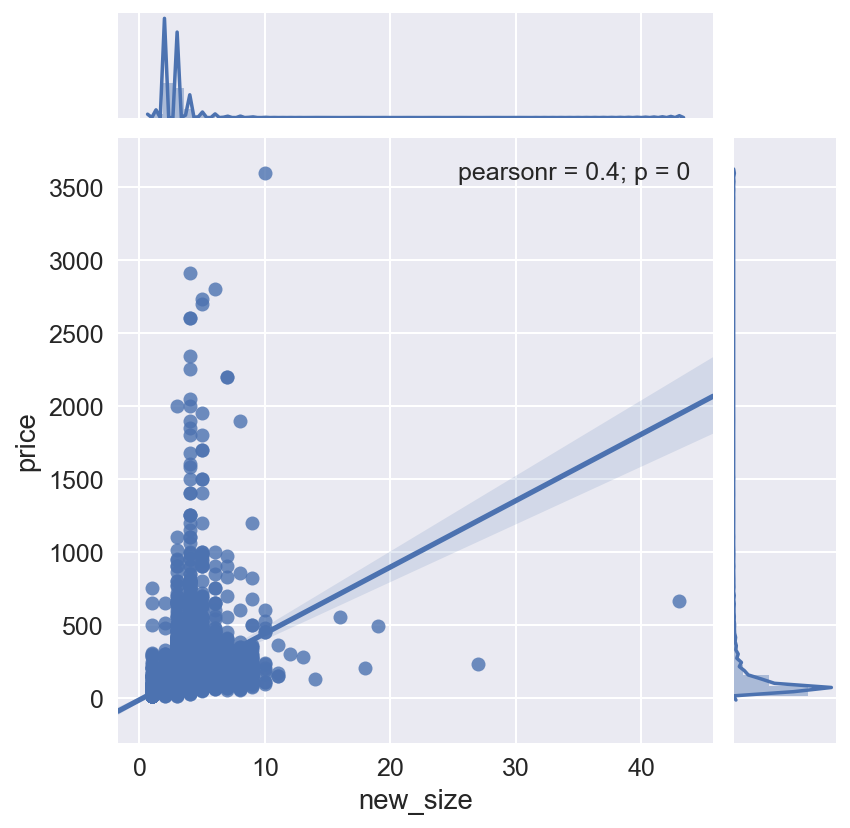

In [27]:
sns.jointplot(x=train['new_size'], y=train['price'], kind='reg')

In [28]:
# Combining traing and testing Datasets
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.price.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['price'], axis=1, inplace=True)
print("Train data size is : {}".format(train.shape))
print("Test data size is : {}".format(test.shape))
print("Combined dataset size is : {}".format(all_data.shape))

Train data size is : (13313, 9)
Test data size is : (1480, 9)
Combined dataset size is : (14793, 8)


In [29]:
# Find Missing Ratio of Dataset
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data

,Missing Ratio
society,41.391199
balcony,4.576489
bath,0.540796
new_size,0.121679
location,0.006760


Text(0.5,1,'Percent missing data by feature')

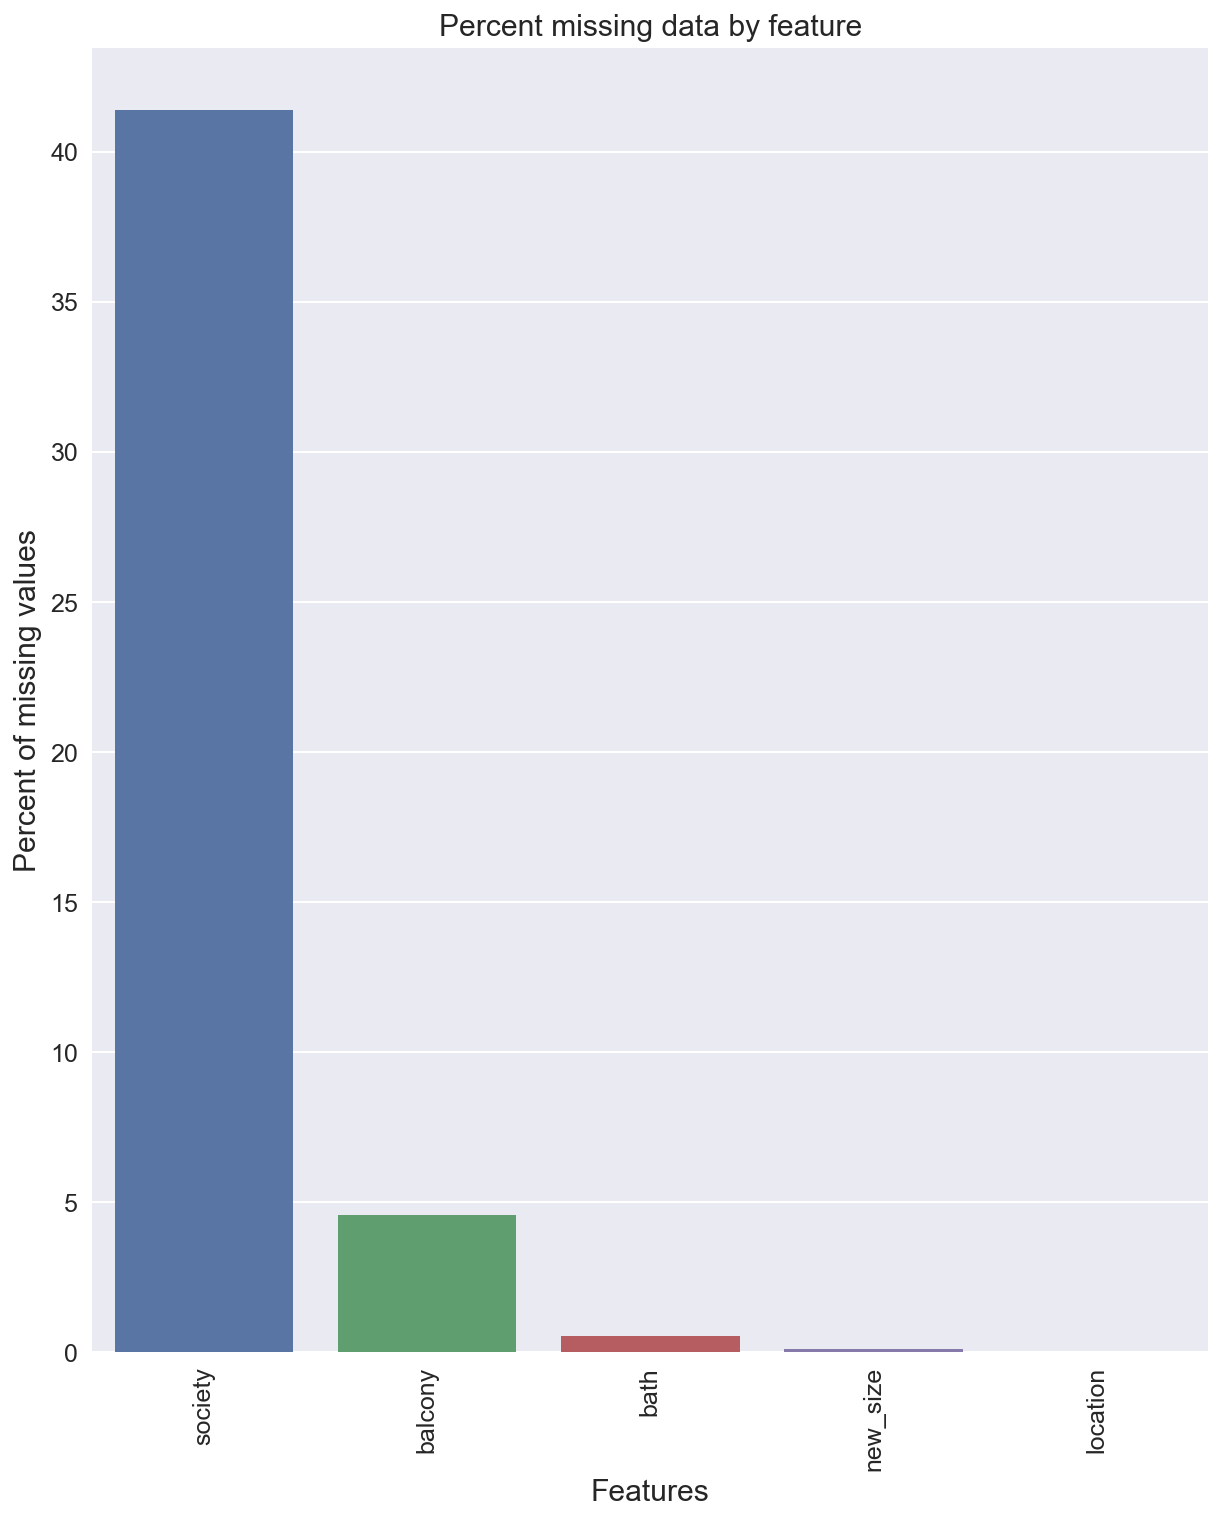

In [30]:
#Percent missing data by feature
f, ax = plt.subplots(figsize=(10, 12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

In [31]:
#Impute Missing Data and Clean Data
all_data["society"] = all_data["society"].fillna("None")
all_data["balcony"] = all_data["balcony"].fillna(0)
all_data["bath"] = all_data["bath"].fillna(0)
all_data["new_size"] = all_data["new_size"].fillna(0)
all_data["location"] = all_data["location"].fillna("None")

In [32]:
# Check if there are any missing values left
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


In [33]:
from sklearn.preprocessing import LabelEncoder
cols =('area_type', 'availability', 'location', 'society')
# Process columns and apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# Check shape        
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (14793, 8)



 mu = 4.41 and sigma = 0.71



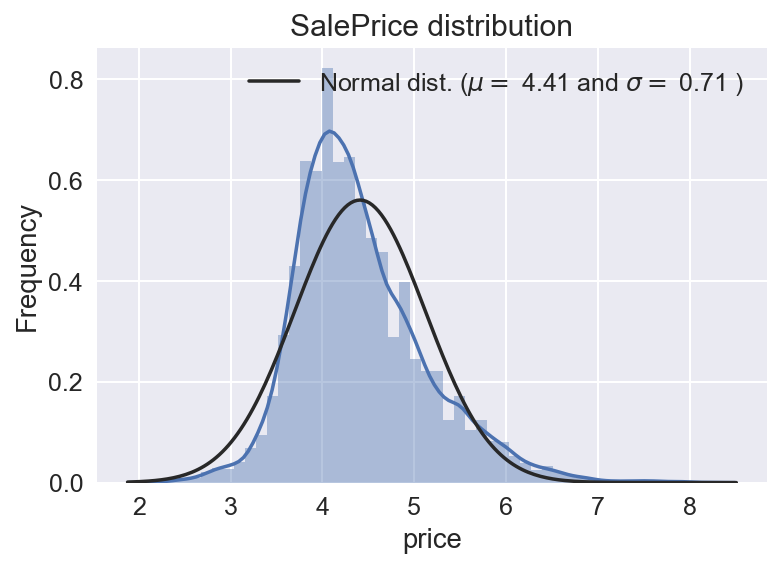

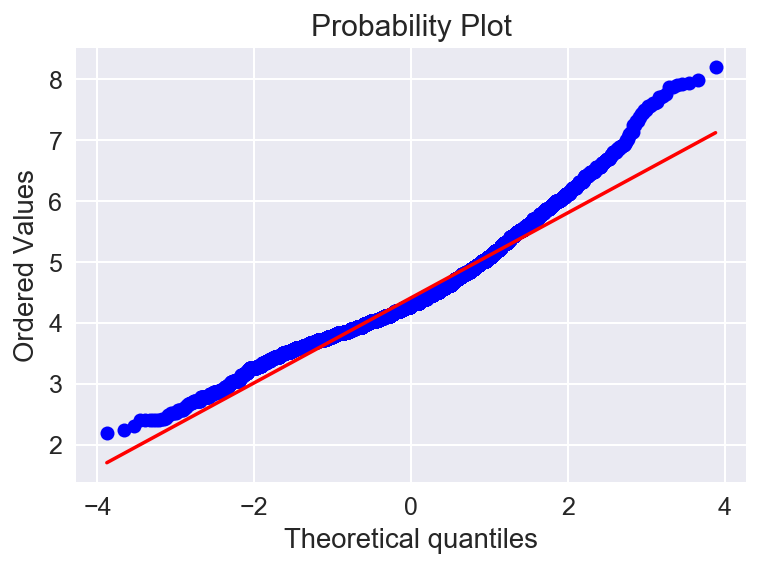

Skewness: 0.849533
Kurtosis: 1.319185


In [34]:
#Fixing "skewed" features.
# We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train["price"] = np.log1p(train["price"])

#Check the new distribution 
sns.distplot(train['price'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['price'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig = plt.figure()
res = stats.probplot(train['price'], plot=plt)
plt.show()

y_train = train.price.values

print("Skewness: %f" % train['price'].skew())
print("Kurtosis: %f" % train['price'].kurt())

In [35]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skewed Features' :skewed_feats})
skewness.head()

,Skewed Features
new_size,4.532885
new_sqft,4.363641
bath,3.923222
location,0.071486
balcony,-0.022170


In [36]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)
    all_data[feat] += 1

There are 8 skewed numerical features to Box Cox transform


In [37]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(14793, 8)


In [38]:
train = all_data[:ntrain]
test = all_data[ntrain:]

In [39]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [40]:
# Cross-validation with k-folds
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [41]:
#Modeling and Predictions
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [42]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))


Lasso score: 0.4357 (0.0197)

ElasticNet score: 0.4357 (0.0197)

Kernel Ridge score: 0.3878 (0.0121)

Gradient Boosting score: 0.2999 (0.0063)

LGBM score: 0.3657 (0.0089)



In [43]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1) 

In [44]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

score = rmsle_cv(averaged_models)
print("Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Averaged base models score: 0.3667 (0.0146)



In [45]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, clf in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(clf)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [46]:

stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = lasso)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.2994 (0.0063)


In [47]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [48]:
#Stacked models
stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
print(rmsle(y_train, stacked_train_pred))

0.24698752813166977


In [49]:
#LightGBM
model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = np.expm1(model_lgb.predict(test.values))
print(rmsle(y_train, lgb_train_pred))

0.3604571964137084


In [50]:
'''RMSE on the entire Train data when averaging'''

print('RMSLE score on train data:')
print(rmsle(y_train,stacked_train_pred*0.70 + lgb_train_pred*0.20 ))

RMSLE score on train data:
0.5198890425124927


In [51]:
#Ensemble Prediction
# Example
Stacked = 1/(0.1077)
LGBM = 1/(0.1159)
Sum = Stacked + LGBM
Stacked = Stacked/Sum
LGBM = LGBM/Sum
print(Stacked,LGBM)

0.5183363148479426 0.4816636851520572


In [52]:
'''RMSE on the entire Train data when averaging'''

print('RMSLE score on train data:')
print(rmsle(y_train,stacked_train_pred*Stacked  + lgb_train_pred*LGBM))

RMSLE score on train data:
0.2877191830783932


In [53]:
ensemble = stacked_pred*Stacked + lgb_pred*LGBM
ensemble

array([ 60.98421862, 308.80125989, 224.26820091, ...,  48.44324059,
        53.39348167,  62.86156862])

In [56]:
#Submission
sub = pd.DataFrame()
sub['price'] = ensemble
sub.to_csv(os.path.join(path,r'submission.csv'),index=False)

In [65]:
#Writing .csv file to .xlsx format
from openpyxl import Workbook
import csv


wb = Workbook()
ws = wb.active
with open('./submission.csv', 'r') as f:
    for row in csv.reader(f):
        ws.append(row)
wb.save(os.path.join(path,r'Predicted_House_Prices.xlsx'))